In [ ]:
# Step 1: Install everything cleanly
!pip install --upgrade xarray zarr gcsfs --quiet

!pip install intake intake-esm --quiet
!pip install fsspec
!pip install cftime --quiet
!pip install adjustText
!pip install cartopy
!pip install cmocean

import numpy as np
import xarray as xr
import zarr
import gcsfs
import importlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd


# Force refresh of plugin registry
importlib.reload(xr.backends.plugins)
print("Available engines:", xr.backends.plugins.list_engines())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; 

In [ ]:
# Load CMIP6 Zarr catalog
catalog_url = "https://cmip6.storage.googleapis.com/pangeo-cmip6.csv"
df = pd.read_csv(catalog_url)

# Filter to day tasmax for historical and ssp245
df_tasmax = df[
    (df["table_id"] == "day") &
    (df["variable_id"] == "tasmax") &
    (df["experiment_id"].isin(["historical", "ssp245"]))
]

# Create lookup: (model, experiment) → zarr path
zstore_lookup = df_tasmax.groupby(["source_id", "experiment_id"])["zstore"].first().to_dict()


In [ ]:
def compute_from_catalog(model, zstore_lookup, historical_period=(1850, 2000), future_period=(2001, 2100)):
    try:
        hist_path = zstore_lookup.get((model, "historical"))
        fut_path = zstore_lookup.get((model, "ssp245"))
        if not hist_path or not fut_path:
            return None

        ds_hist = xr.open_zarr(f"gs://{hist_path}", consolidated=True, storage_options={"token": "anon"})
        ds_fut = xr.open_zarr(f"gs://{fut_path}", consolidated=True, storage_options={"token": "anon"})

        tas_hist = ds_hist["tasmax"].dropna("time")
        tas_fut = ds_fut["tasmax"].dropna("time")
        tas = xr.concat([tas_hist, tas_fut], dim="time")

        annual_max = tas.resample(time="1YE").max()
        annual_mean = annual_max.mean(dim=["lat", "lon"]).to_series()

        hist = annual_mean.loc[str(historical_period[0]):str(historical_period[1])]
        fut = annual_mean.loc[str(future_period[0]):str(future_period[1])]

        def trend(series):
            x = np.arange(len(series))
            return np.polyfit(x, series.values, 1)[0] * 10  # °C/decade

        def count_records(series):
            max_so_far, count = -np.inf, 0
            for val in series:
                if val > max_so_far:
                    max_so_far = val
                    count += 1
            return count

        return {
            "model": model,
            "warming_trend": trend(fut),
            "record_ratio": count_records(fut) / count_records(hist)
        }
    except Exception as e:
        print(f"❌ Failed for {model}: {e}")
        return None


In [ ]:
models = ["ACCESS-CM2", "ACCESS-ESM1-5", "AWI-CM-1-1-MR", "CAMS-CSM1-0", "CMCC-CM2-SR5", "CMCC-ESM2",
          "CNRM-CM6-1", "CNRM-CM6-1-HR", "CNRM-ESM2-1", "EC-Earth3", "EC-Earth3-CC",
          "EC-Earth3-Veg", "EC-Earth3-Veg-LR", "GFDL-CM4", "GFDL-ESM4", "HadGEM3-GC31-LL",
          "IITM-ESM", "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR",
          "NorESM2-LM", "NorESM2-MM", "TaiESM1", "UKESM1-0-LL"]

models_with_both = [
    model for model in models
    if (model, "historical") in zstore_lookup and (model, "ssp245") in zstore_lookup
]

results = []
for model in models_with_both:
    result = compute_from_catalog(model, zstore_lookup)
    if result:
        results.append(result)

df = pd.DataFrame(results)
print(f"✅ Finished {len(df)} models")
df.head()


✅ Finished 18 models


,model,warming_trend,record_ratio
0,ACCESS-CM2,0.323321,8.250000
1,AWI-CM-1-1-MR,0.199523,3.666667
2,CAMS-CSM1-0,0.130293,2.111111
3,CMCC-ESM2,0.341458,1.470588
4,CNRM-CM6-1,0.276810,2.000000


In [ ]:
# === Plot Style Setup for Google Colab (Jupyter-style aesthetics) ===
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats

# Use retina display for sharper visuals
set_matplotlib_formats('retina')

# Choose a consistent style
plt.style.use('default')  # Options: 'classic', 'seaborn-v0_8', etc.

# Set figure DPI for better sharpness
mpl.rcParams['figure.dpi'] = 120

# Font and axis formatting
mpl.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'font.family': 'DejaVu Sans',  # Try 'Arial' or 'Helvetica' if installed
    'figure.facecolor': 'white',
    'savefig.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
})


<ipython-input-5-805216771>:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

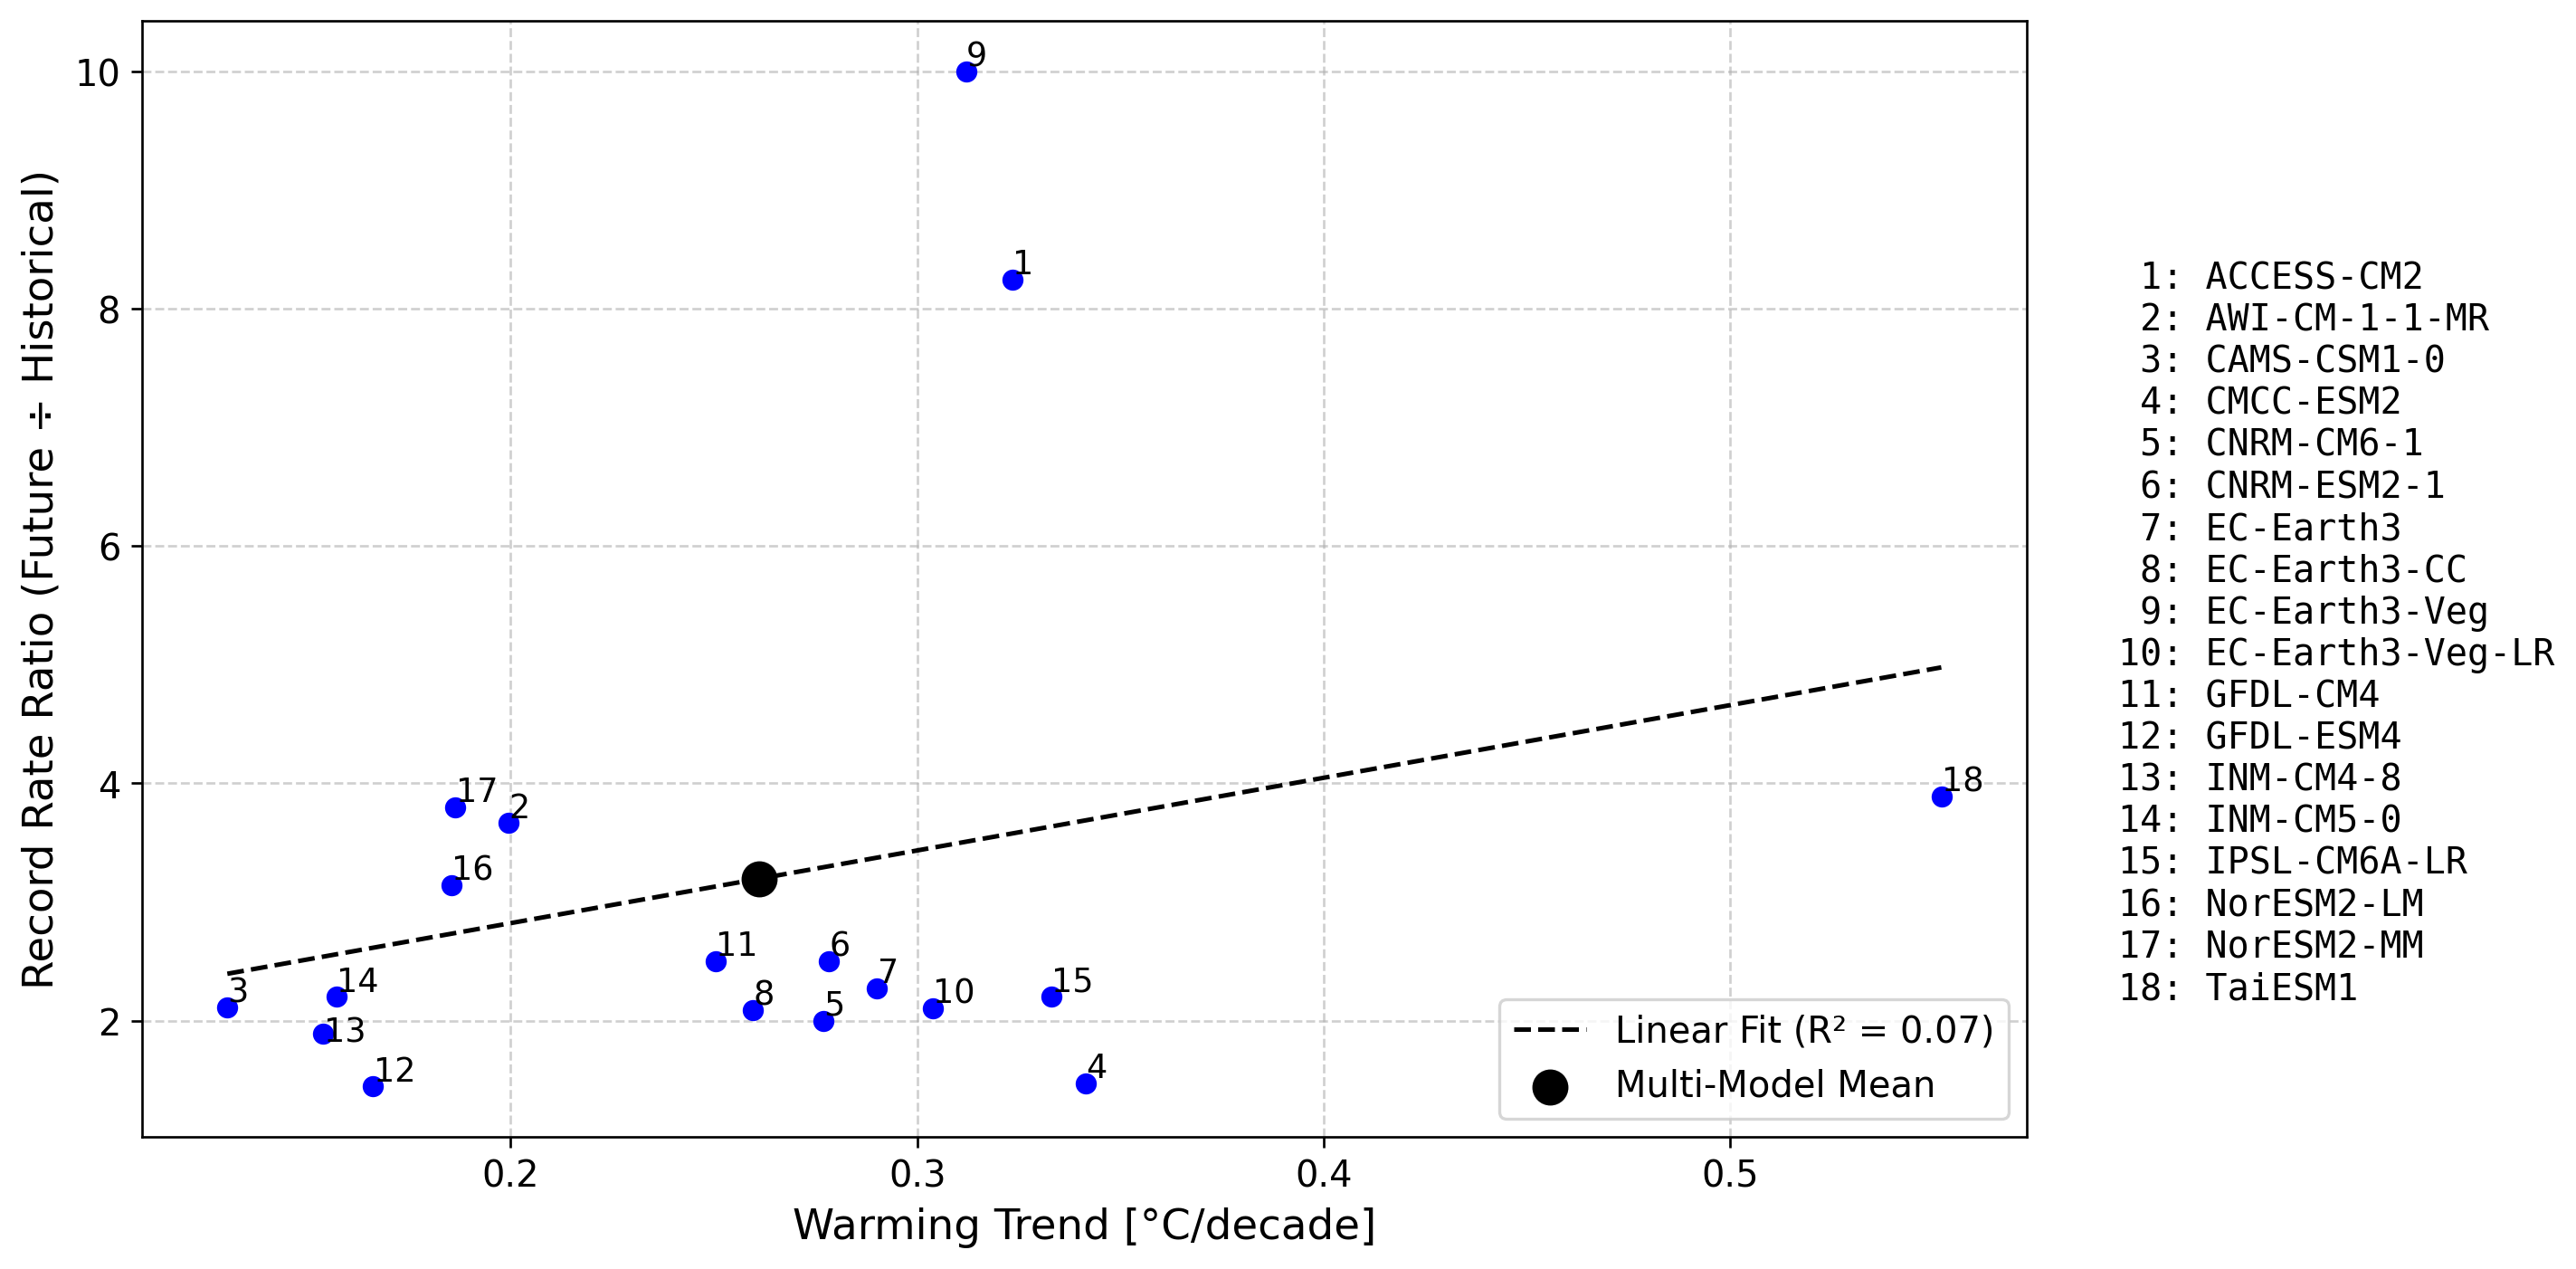

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from adjustText import adjust_text
import numpy as np

# Sort models alphabetically and assign a unique ID
df = df.sort_values("model").reset_index(drop=True)
df["model_number"] = df.index + 1

# Fit linear regression model
reg = LinearRegression()
X = df["warming_trend"].values.reshape(-1, 1)
y = df["record_ratio"].values
reg.fit(X, y)
r2 = reg.score(X, y)

# Start figure with room on right for model key
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df["warming_trend"], df["record_ratio"], color='blue', zorder=3)

# Add model number labels with smart placement
texts = []
for _, row in df.iterrows():
    texts.append(ax.text(row["warming_trend"], row["record_ratio"], str(row["model_number"]), fontsize=11))
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

# Add regression line
x_line = np.linspace(df["warming_trend"].min(), df["warming_trend"].max(), 100).reshape(-1, 1)
y_line = reg.predict(x_line)
ax.plot(x_line, y_line, 'k--', label=f"Linear Fit (R² = {r2:.2f})", linewidth=1.5)

# Add multi-model mean marker
mean_x = df["warming_trend"].mean()
mean_y = df["record_ratio"].mean()
ax.scatter(mean_x, mean_y, color='black', s=120, marker='o', label='Multi-Model Mean', zorder=4)

# Axis labels and styling
ax.set_xlabel("Warming Trend [°C/decade]", fontsize=14)
ax.set_ylabel("Record Rate Ratio (Future ÷ Historical)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(fontsize=12, loc="lower right")

# Add side legend for model key (aligned left, mono-spaced)
key_text = "\n".join([f"{row['model_number']:>2}: {row['model']}" for _, row in df.iterrows()])
fig.text(0.82, 0.5, key_text, fontsize=12, va='center', ha='left', family='monospace')

# Adjust layout to make room for key
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.savefig("my_figure.png", dpi=300, bbox_inches="tight")

from google.colab import files
files.download("my_figure.png")

plt.show()





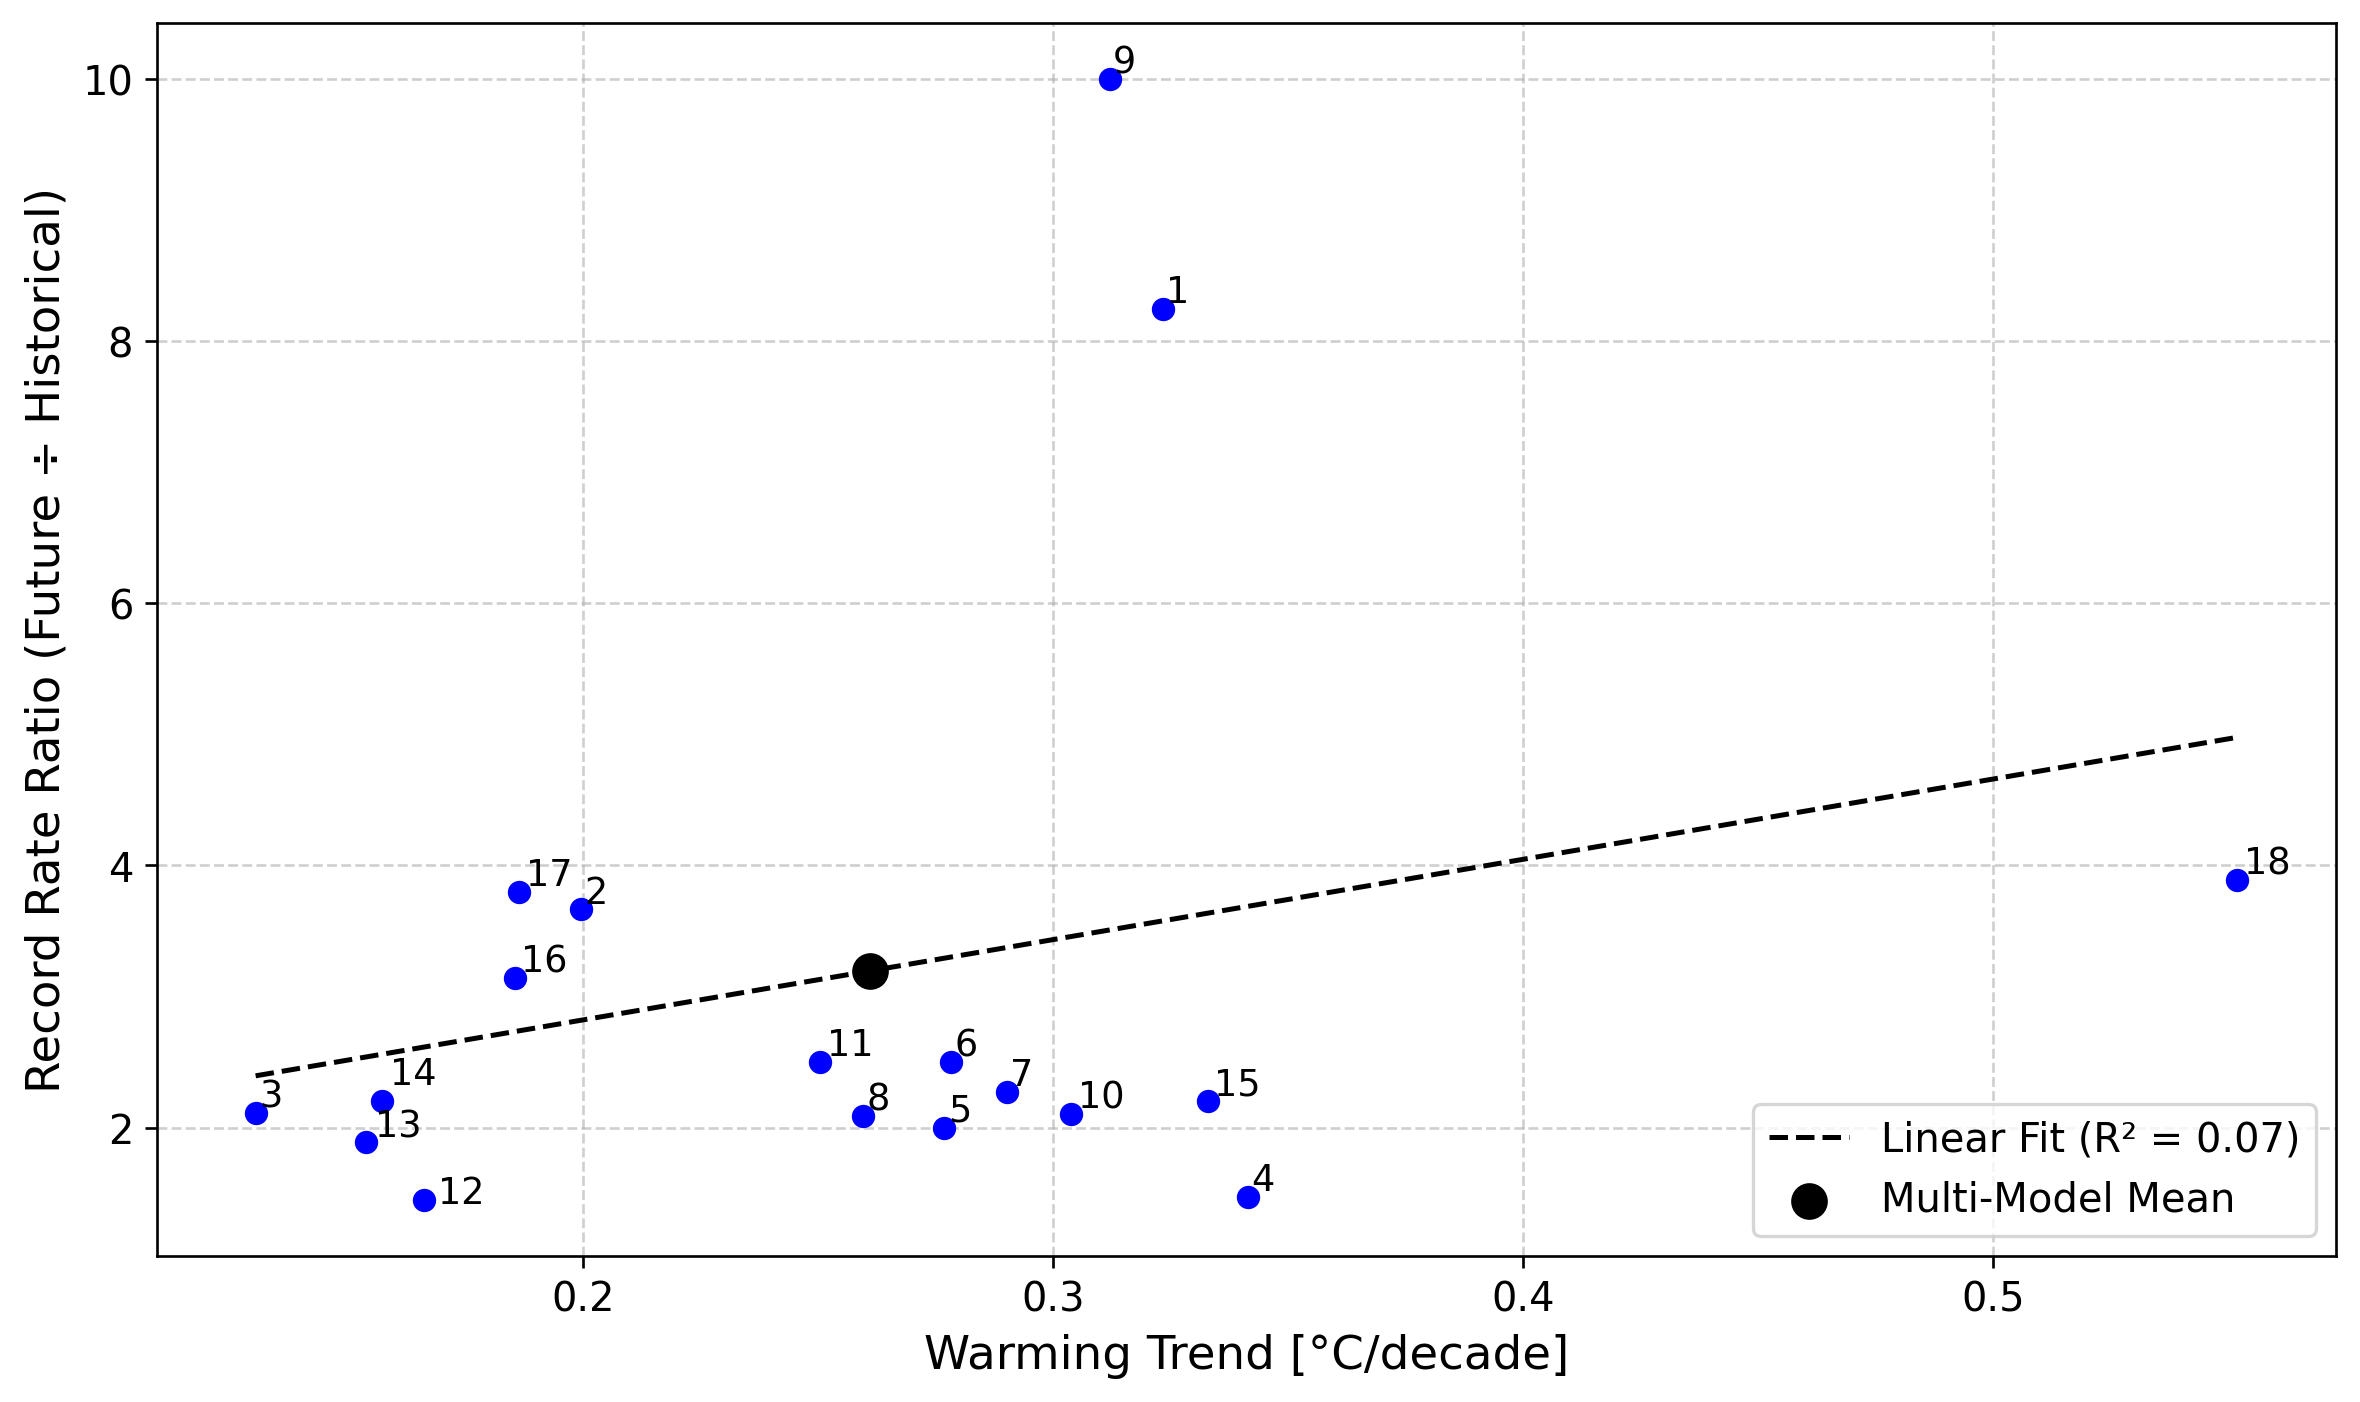

In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from adjustText import adjust_text
import numpy as np

# Sort and assign model numbers
df = df.sort_values("model").reset_index(drop=True)
df["model_number"] = df.index + 1  # 1-based indexing for labeling

# Fit regression
X = df["warming_trend"].values.reshape(-1, 1)
y = df["record_ratio"].values
reg = LinearRegression().fit(X, y)
r2 = reg.score(X, y)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df["warming_trend"], df["record_ratio"], color='blue', zorder=2)

# Add model number labels with arrows
texts = []
for _, row in df.iterrows():
    texts.append(ax.text(row["warming_trend"], row["record_ratio"], str(row["model_number"]), fontsize=11))
adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

# Regression line
x_line = np.linspace(df["warming_trend"].min(), df["warming_trend"].max(), 100).reshape(-1, 1)
y_line = reg.predict(x_line)
ax.plot(x_line, y_line, 'k--', label=f"Linear Fit (R² = {r2:.2f})", linewidth=1.5)

# Multi-model mean
mean_x = df["warming_trend"].mean()
mean_y = df["record_ratio"].mean()
ax.scatter(mean_x, mean_y, color='black', s=100, marker='o', label='Multi-Model Mean', zorder=3)

# Styling
ax.set_xlabel("Warming Trend [°C/decade]", fontsize=14)
ax.set_ylabel("Record Rate Ratio (Future ÷ Historical)", fontsize=14)
ax.tick_params(labelsize=12)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(fontsize=12, loc="lower right")

plt.tight_layout()
plt.show()


📈 Plotting TXx for EC-Earth3-Veg...


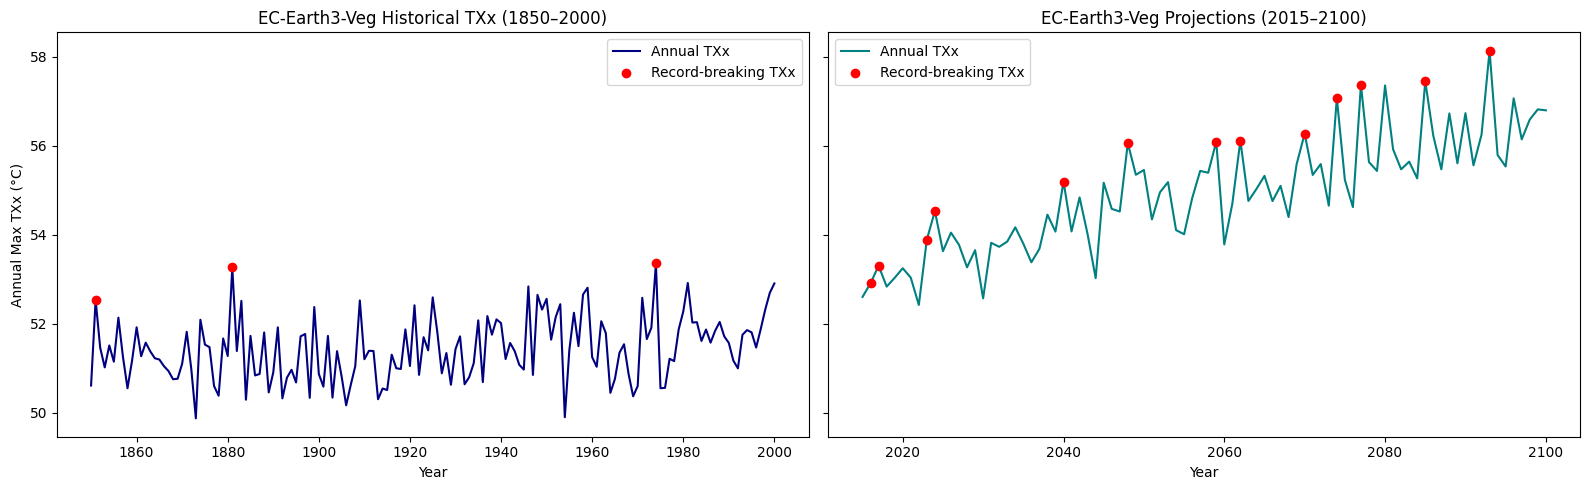

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

def plot_absolute_record_breaking_txx(model_name, member_id, zstore_lookup, historical_years=(1850, 2000), projection_years=(2015, 2100)):
    print(f"📈 Plotting TXx for {model_name}...")

    try:
        # Load paths
        hist_path = zstore_lookup.get((model_name, "historical"))
        proj_path = zstore_lookup.get((model_name, "ssp245"))
        if not hist_path or not proj_path:
            print(f"❌ No data for {model_name}")
            return

        # Load datasets
        ds_hist = xr.open_zarr(f"gs://{hist_path}", consolidated=True, storage_options={"token": "anon"})
        ds_proj = xr.open_zarr(f"gs://{proj_path}", consolidated=True, storage_options={"token": "anon"})

        # Combine data
        tas_hist = ds_hist["tasmax"].dropna("time")
        tas_proj = ds_proj["tasmax"].dropna("time")
        tas = xr.concat([tas_hist, tas_proj], dim="time")

        # Convert to annual max TXx (absolute, not mean)
        annual_max = tas.resample(time="YE").max(dim="time")  # 'YE' = year-end

        # Global absolute max for each year
        annual_max_abs = annual_max.max(dim=["lat", "lon"])

        # Split into historical and projection
        hist = annual_max_abs.sel(time=slice(str(historical_years[0]), str(historical_years[1])))
        fut = annual_max_abs.sel(time=slice(str(projection_years[0]), str(projection_years[1])))

        def get_record_breakers(series):
            max_so_far = -np.inf
            is_record = []
            for i, val in enumerate(series):
                if i == 0:
                    is_record.append(False)  # First year never a record
                elif val > max_so_far:
                    is_record.append(True)
                    max_so_far = val
                else:
                    is_record.append(False)
                    max_so_far = max(max_so_far, val)
            return np.array(is_record)

        # Historical records
        hist_years = pd.to_datetime(hist["time"].values).year
        hist_values = hist.values - 273.15  # Kelvin to °C
        hist_records = get_record_breakers(hist_values)

        # Future records
        fut_years = pd.to_datetime(fut["time"].values).year
        fut_values = fut.values - 273.15
        fut_records = get_record_breakers(fut_values)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

        # Historical plot
        axes[0].plot(hist_years, hist_values, label="Annual TXx", color='navy')
        axes[0].scatter(hist_years[hist_records], hist_values[hist_records], color='red', label='Record-breaking TXx', zorder=5)
        axes[0].set_title(f"{model_name} Historical TXx ({historical_years[0]}–{historical_years[1]})")
        axes[0].set_xlabel("Year")
        axes[0].set_ylabel("Annual Max TXx (°C)")
        axes[0].legend()

        # Future plot
        axes[1].plot(fut_years, fut_values, label="Annual TXx", color='teal')
        axes[1].scatter(fut_years[fut_records], fut_values[fut_records], color='red', label='Record-breaking TXx', zorder=5)
        axes[1].set_title(f"{model_name} Projections ({projection_years[0]}–{projection_years[1]})")
        axes[1].set_xlabel("Year")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Failed for {model_name}: {e}")

plot_absolute_record_breaking_txx("EC-Earth3-Veg", "r1i1p1f1", zstore_lookup)



📈 Plotting TXx for ACCESS-CM2...


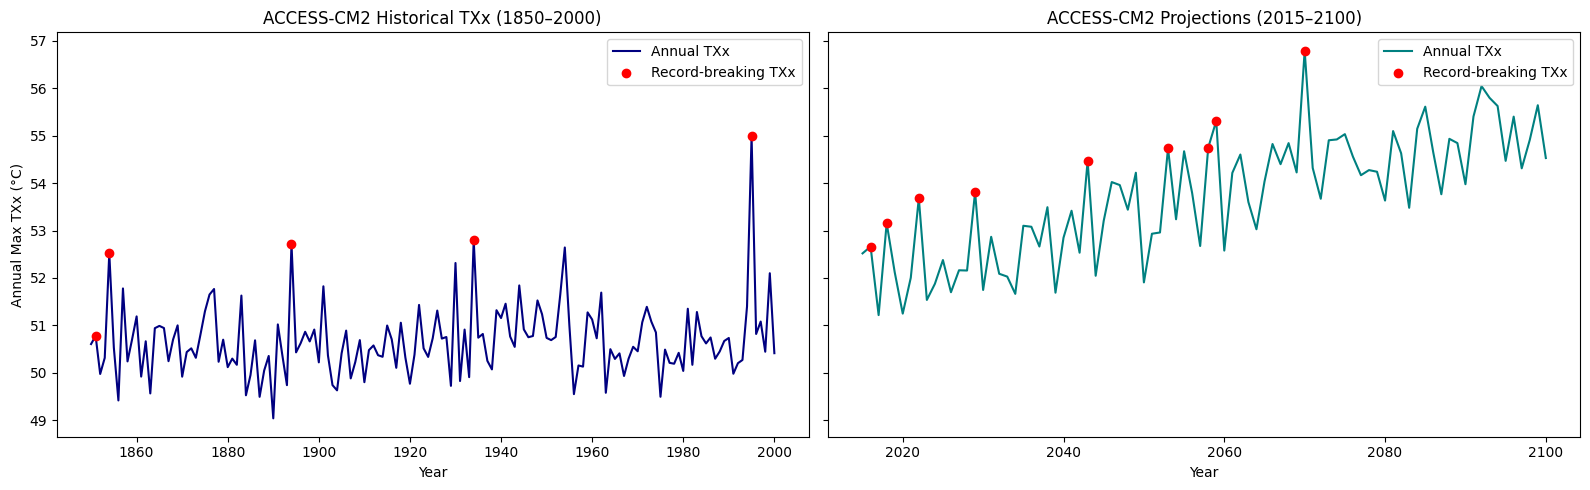

In [ ]:
plot_absolute_record_breaking_txx("ACCESS-CM2", "r1i1p1f1", zstore_lookup)

🗺️ Plotting TXx maps for ACCESS-CM2 (r1i1p1f1)...
🔥 Historical hottest TXx: 54.99 °C at (5.62°N, 32.81°E)
🔥 Projection hottest TXx: 56.79 °C at (30.62°N, 74.06°E)


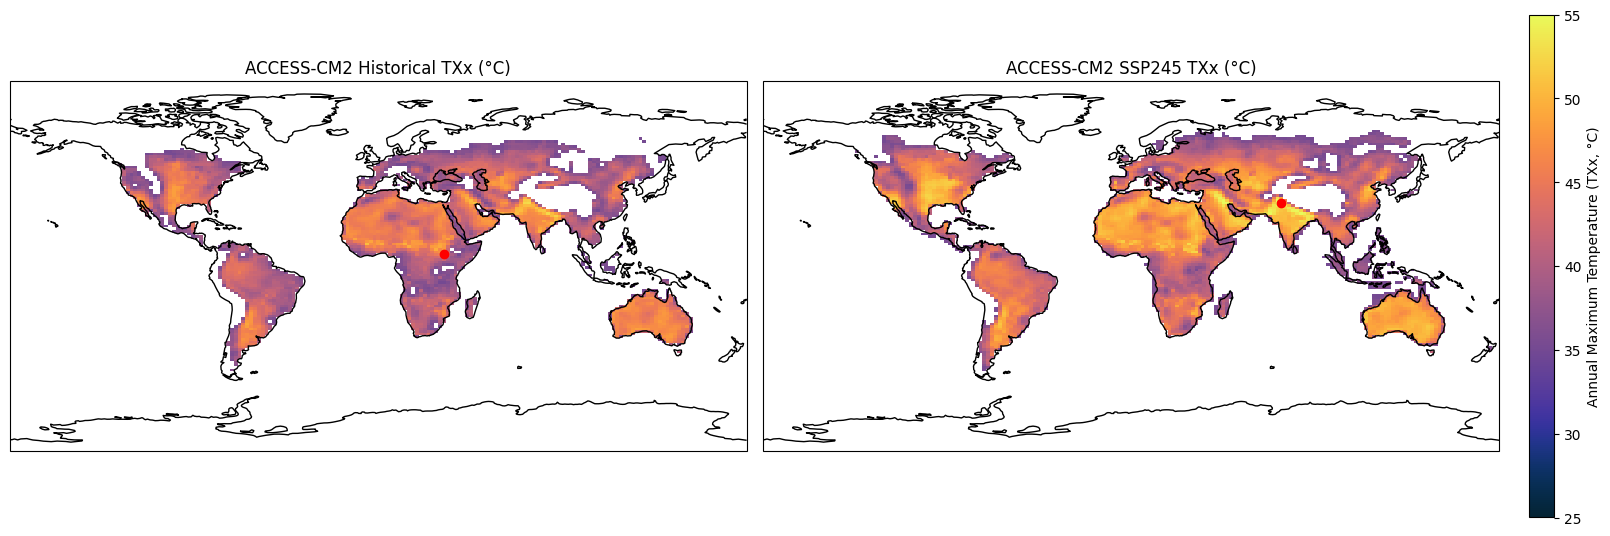

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

def plot_txx_maps(model_name, member_id, zstore_lookup, threshold=35):
    print(f"🗺️ Plotting TXx maps for {model_name} ({member_id})...")

    hist_zstore = zstore_lookup.get((model_name, "historical"))
    proj_zstore = zstore_lookup.get((model_name, "ssp245"))
    if not hist_zstore or not proj_zstore:
        print(f"❌ No data for {model_name}")
        return

    # Load datasets
    ds_hist = xr.open_zarr(f"gs://{hist_zstore}", consolidated=True, storage_options={"token": "anon"})
    ds_proj = xr.open_zarr(f"gs://{proj_zstore}", consolidated=True, storage_options={"token": "anon"})

    tas_hist = ds_hist["tasmax"].dropna("time")
    tas_proj = ds_proj["tasmax"].dropna("time")

    # Compute annual max TXx
    annual_max_hist = tas_hist.resample(time="YE").max(dim="time")
    annual_max_proj = tas_proj.resample(time="YE").max(dim="time")

    # Compute TXx fields
    txx_hist = annual_max_hist.max(dim="time") - 273.15
    txx_proj = annual_max_proj.max(dim="time") - 273.15

    # Get hottest point (value + lat/lon) for historical
    hist_max_val = txx_hist.max().compute().item()
    hist_max_loc = np.unravel_index(np.argmax(txx_hist.values), txx_hist.shape)
    hist_lat = txx_hist.lat.values[hist_max_loc[0]]
    hist_lon = txx_hist.lon.values[hist_max_loc[1]]

    # Get hottest point (value + lat/lon) for projection
    proj_max_val = txx_proj.max().compute().item()
    proj_max_loc = np.unravel_index(np.argmax(txx_proj.values), txx_proj.shape)
    proj_lat = txx_proj.lat.values[proj_max_loc[0]]
    proj_lon = txx_proj.lon.values[proj_max_loc[1]]

    print(f"🔥 Historical hottest TXx: {hist_max_val:.2f} °C at ({hist_lat:.2f}°N, {hist_lon:.2f}°E)")
    print(f"🔥 Projection hottest TXx: {proj_max_val:.2f} °C at ({proj_lat:.2f}°N, {proj_lon:.2f}°E)")

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), subplot_kw={"projection": ccrs.PlateCarree()}, constrained_layout=True)
    vmin, vmax = 25, 55
    cmap = cmocean.cm.thermal

    for ax, data, title, max_lat, max_lon in zip(
        axes,
        [txx_hist, txx_proj],
        [f"{model_name} Historical TXx (°C)", f"{model_name} SSP245 TXx (°C)"],
        [hist_lat, proj_lat],
        [hist_lon, proj_lon],
    ):
        im = data.where(data >= threshold).plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            add_colorbar=False
        )
        ax.coastlines()
        ax.set_title(title)

        # Red dot for hottest point only
        ax.plot(max_lon, max_lat, "ro", markersize=6)

    # Add colorbar
    cbar = fig.colorbar(im, ax=axes, orientation="vertical", shrink=0.85, pad=0.02)
    cbar.set_label("Annual Maximum Temperature (TXx, °C)")

    plt.show()

plot_txx_maps("ACCESS-CM2", "r1i1p1f1", zstore_lookup)







| Model           | Missing Experiment(s) |
| --------------- | --------------------- |
| HadGEM3-GC31-LL | historical            |
| CNRM-CM6-1-HR   | historical + ssp245   |
| ACCESS-ESM1-5   | ssp245                |
| UKESM1-0-LL     | historical            |


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


In [ ]:
file_paths = [
    "/content/drive/My Drive/berkdata/Complete_TMAX_Daily_LatLong1_1990.nc",
    "/content/drive/My Drive/berkdata/Complete_TMAX_Daily_LatLong1_2000.nc",
    "/content/drive/My Drive/berkdata/Complete_TMAX_Daily_LatLong1_2010.nc",
]


In [ ]:
!pip install cartopy fsspec zarr --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.0 MB/s eta 0:00:00


In [ ]:
!pip install gcsfs


In [ ]:
import pandas as pd
import xarray as xr
import numpy as np

# Load Pangeo CMIP6 catalog (daily data)
catalog_url = "https://cmip6.storage.googleapis.com/pangeo-cmip6.csv"
df = pd.read_csv(catalog_url)

# Filter to daily tasmax for historical and ssp245
df_tasmax = df[
    (df["table_id"] == "day") &
    (df["variable_id"] == "tasmax") &
    (df["experiment_id"].isin(["historical", "ssp245"]))
]

# Create lookup dictionary: (model, experiment) -> Zarr path
zstore_lookup = df_tasmax.groupby(["source_id", "experiment_id"])["zstore"].first().to_dict()

def compute_from_catalog(model, zstore_lookup, historical_period=(1850, 2000), future_period=(2001, 2100)):
    try:
        hist_path = zstore_lookup.get((model, "historical"))
        fut_path = zstore_lookup.get((model, "ssp245"))
        if not hist_path or not fut_path:
            return None

        ds_hist = xr.open_zarr(f"gs://{hist_path}", consolidated=True, storage_options={"token": "anon"})
        ds_fut = xr.open_zarr(f"gs://{fut_path}", consolidated=True, storage_options={"token": "anon"})

        tas_hist = ds_hist["tasmax"].dropna("time")
        tas_fut = ds_fut["tasmax"].dropna("time")
        tas = xr.concat([tas_hist, tas_fut], dim="time")

        # Convert Kelvin to Celsius if needed
        if tas.attrs.get("units", "").lower() in ["k", "kelvin"]:
            tas = tas - 273.15
            tas.attrs["units"] = "degC"

        # Compute TXx: annual maximum tasmax
        annual_max = tas.resample(time="1Y").max()
        annual_mean = annual_max.mean(dim=["lat", "lon"]).to_series()

        # Historical and future slices
        hist = annual_mean.loc[str(historical_period[0]):str(historical_period[1])]
        fut = annual_mean.loc[str(future_period[0]):str(future_period[1])]

        def trend(series):
            x = np.arange(len(series))
            return np.polyfit(x, series.values, 1)[0] * 10  # °C/decade

        def count_records(series):
            max_so_far = -np.inf
            count = 0
            for val in series:
                if val > max_so_far:
                    max_so_far = val
                    count += 1
            return count

        return {
            "model": model,
            "warming_trend": trend(fut),
            "record_ratio": count_records(fut) / count_records(hist)
        }

    except Exception as e:
        print(f"❌ Failed for {model}: {e}")
        return None

# List of desired models (you can expand this)

models = [
    "ACCESS-CM2",
    "AWI-CM-1-1-MR",
    "CAMS-CSM1-0",
    "CMCC-ESM2",
    "CNRM-CM6-1",
    "CNRM-ESM2-1",
    "EC-Earth3",
    "EC-Earth3-CC",
    "EC-Earth3-Veg",
    "EC-Earth3-Veg-LR",
    "GFDL-CM4",
    "GFDL-ESM4",
    "INM-CM4-8",
    "INM-CM5-0",
    "IPSL-CM6A-LR",
    "NorESM2-LM",
    "NorESM2-MM",
    "TaiESM1"
]

# Keep models that have both experiments
models_with_both = [
    model for model in models
    if (model, "historical") in zstore_lookup and (model, "ssp245") in zstore_lookup
]

# Run analysis
results = []
for model in models_with_both:
    print(f"🔍 Processing {model}...")
    result = compute_from_catalog(model, zstore_lookup)
    if result:
        results.append(result)

# Store and inspect results
df_results = pd.DataFrame(results)
print("✅ Finished processing models:")
print(df_results)


🔍 Processing ACCESS-CM2...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing AWI-CM-1-1-MR...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing CAMS-CSM1-0...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing CMCC-ESM2...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


🔍 Processing CNRM-CM6-1...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing CNRM-ESM2-1...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing EC-Earth3...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing EC-Earth3-CC...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing EC-Earth3-Veg...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing EC-Earth3-Veg-LR...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing GFDL-CM4...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


🔍 Processing GFDL-ESM4...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


🔍 Processing INM-CM4-8...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


🔍 Processing INM-CM5-0...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


🔍 Processing IPSL-CM6A-LR...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


🔍 Processing NorESM2-LM...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


🔍 Processing NorESM2-MM...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


🔍 Processing TaiESM1...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


✅ Finished processing models:
               model  warming_trend  record_ratio
0         ACCESS-CM2       0.323321      8.250000
1      AWI-CM-1-1-MR       0.199523      3.666667
2        CAMS-CSM1-0       0.130293      2.111111
3          CMCC-ESM2       0.341458      1.470588
4         CNRM-CM6-1       0.276811      2.000000
5        CNRM-ESM2-1       0.278325      2.500000
6          EC-Earth3       0.290144      2.272727
7       EC-Earth3-CC       0.259598      2.090909
8      EC-Earth3-Veg       0.311992     10.000000
9   EC-Earth3-Veg-LR       0.303770      2.100000
10          GFDL-CM4       0.250349      2.500000
11         GFDL-ESM4       0.166097      1.444444
12         INM-CM4-8       0.153880      1.888889
13         INM-CM5-0       0.157102      2.200000
14      IPSL-CM6A-LR       0.332903      2.200000
15        NorESM2-LM       0.185380      3.142857
16        NorESM2-MM       0.186427      3.800000
17           TaiESM1       0.551879      3.888889


In [ ]:
import pandas as pd
import xarray as xr
import numpy as np
from tqdm import tqdm

# Load Pangeo CMIP6 catalog
catalog_url = "https://cmip6.storage.googleapis.com/pangeo-cmip6.csv"
df = pd.read_csv(catalog_url)

# Filter to daily tasmax for historical experiment only
df_tasmax = df[
    (df["table_id"] == "day") &
    (df["variable_id"] == "tasmax") &
    (df["experiment_id"] == "historical")
]

# Create lookup dictionary: (model, experiment) -> Zarr path
zstore_lookup = df_tasmax.groupby(["source_id", "experiment_id"])["zstore"].first().to_dict()

# ✅ Load observed 99th percentile TXx (already processed)
obs_path = "/content/drive/MyDrive/berkdata/output/tmax_99th_percentile.nc"
obs_ds = xr.open_dataset(obs_path)
obs_var = list(obs_ds.data_vars)[0]
obs = obs_ds[obs_var].rename({"latitude": "lat", "longitude": "lon"}).sel(lat=slice(-60, 60))

# Helper: preprocess model data
def preprocess_model(model_path):
    ds = xr.open_zarr(f"gs://{model_path}", consolidated=True, storage_options={"token": "anon"})
    ds = ds.sel(time=slice("1990", "2014"))
    tas = ds["tasmax"]

    if tas.attrs.get("units", "").lower() in ["k", "kelvin"]:
        tas = tas - 273.15

    tas_max = tas.resample(time="1Y").max()
    txx = tas_max.quantile(0.99, dim="time", skipna=True).sel(lat=slice(-60, 60))
    return txx

# Metric functions
def calculate_spatial_r2(m, o):
    m_flat, o_flat = m.values.flatten(), o.values.flatten()
    valid = ~np.isnan(m_flat) & ~np.isnan(o_flat)
    m_flat, o_flat = m_flat[valid], o_flat[valid]
    if len(m_flat) == 0: return np.nan
    m_flat -= np.mean(m_flat)
    o_flat -= np.mean(o_flat)
    return (np.cov(m_flat, o_flat)[0, 1] ** 2) / (np.var(m_flat) * np.var(o_flat))

def calculate_metrics(model_data, obs_data):
    obs_interp = obs_data.interp(lat=model_data.lat, lon=model_data.lon)
    bias = float((model_data - obs_interp).mean().values)
    rmse = float(np.sqrt(((model_data - obs_interp) ** 2).mean().values))
    r2 = calculate_spatial_r2(model_data, obs_interp)
    return {"rmse_mean": rmse, "bias_mean": bias, "r_squared": r2}

# List of 18 target models
models = [
    "ACCESS-CM2", "AWI-CM-1-1-MR", "CAMS-CSM1-0", "CMCC-ESM2", "CNRM-CM6-1", "CNRM-ESM2-1",
    "EC-Earth3", "EC-Earth3-CC", "EC-Earth3-Veg", "EC-Earth3-Veg-LR", "GFDL-CM4", "GFDL-ESM4",
    "INM-CM4-8", "INM-CM5-0", "IPSL-CM6A-LR", "NorESM2-LM", "NorESM2-MM", "TaiESM1"
]

results = []
for model in tqdm(models, desc="Processing models"):
    key = (model, "historical")
    if key in zstore_lookup:
        try:
            print(f"🔍 Processing {model}...")
            model_path = zstore_lookup[key]
            model_txx = preprocess_model(model_path)
            metrics = calculate_metrics(model_txx, obs)
            metrics.update({"model": model, "percentile": "99th"})
            results.append(metrics)
        except Exception as e:
            print(f"⚠️ Failed for {model}: {e}")
    else:
        print(f"❌ Missing {model} in catalog.")

# Save and display results
df = pd.DataFrame(results).sort_values("rmse_mean")
df.to_csv("/content/drive/MyDrive/berkdata/output/txx_99th_metrics.csv", index=False)
print("✅ Done. Saved to /content/drive/MyDrive/berkdata/output/txx_99th_metrics.csv")
df.head()


Processing models:   0%|          | 0/18 [00:00<?, ?it/s]

🔍 Processing ACCESS-CM2...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:   6%|▌         | 1/18 [00:19<05:25, 19.16s/it]

🔍 Processing AWI-CM-1-1-MR...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:  11%|█         | 2/18 [01:02<08:56, 33.54s/it]

🔍 Processing CAMS-CSM1-0...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:  17%|█▋        | 3/18 [01:34<08:12, 32.86s/it]

🔍 Processing CMCC-ESM2...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
Processing models:  22%|██▏       | 4/18 [02:11<07:58, 34.21s/it]

🔍 Processing CNRM-CM6-1...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:  28%|██▊       | 5/18 [02:33<06:29, 29.93s/it]

🔍 Processing CNRM-ESM2-1...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:  33%|███▎      | 6/18 [02:55<05:26, 27.19s/it]

🔍 Processing EC-Earth3...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:  39%|███▉      | 7/18 [04:11<07:55, 43.18s/it]

🔍 Processing EC-Earth3-CC...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:  44%|████▍     | 8/18 [05:30<09:04, 54.47s/it]

🔍 Processing EC-Earth3-Veg...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:  50%|█████     | 9/18 [06:46<09:13, 61.46s/it]

🔍 Processing EC-Earth3-Veg-LR...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:  56%|█████▌    | 10/18 [07:18<06:56, 52.12s/it]

🔍 Processing GFDL-CM4...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
Processing models:  61%|██████    | 11/18 [07:28<04:35, 39.32s/it]

🔍 Processing GFDL-ESM4...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
Processing models:  67%|██████▋   | 12/18 [08:00<03:43, 37.17s/it]

🔍 Processing INM-CM4-8...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
Processing models:  72%|███████▏  | 13/18 [08:15<02:31, 30.34s/it]

🔍 Processing INM-CM5-0...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
Processing models:  78%|███████▊  | 14/18 [08:29<01:42, 25.61s/it]

🔍 Processing IPSL-CM6A-LR...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:513: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
Processing models:  83%|████████▎ | 15/18 [08:44<01:06, 22.23s/it]

🔍 Processing NorESM2-LM...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
Processing models:  89%|████████▉ | 16/18 [08:55<00:37, 18.93s/it]

🔍 Processing NorESM2-MM...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
Processing models:  94%|█████████▍| 17/18 [09:28<00:23, 23.02s/it]

🔍 Processing TaiESM1...


<string>:7: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.
Processing models: 100%|██████████| 18/18 [10:00<00:00, 33.38s/it]

✅ Done. Saved to /content/drive/MyDrive/berkdata/output/txx_99th_metrics.csv


,rmse_mean,bias_mean,r_squared,model,percentile
10,3.987294,2.482644,0.824697,GFDL-CM4,99th
14,4.056452,1.333776,0.697885,IPSL-CM6A-LR,99th
0,4.102715,3.035418,0.828137,ACCESS-CM2,99th
17,4.154614,-2.974677,0.809055,TaiESM1,99th
4,4.209870,2.937319,0.814854,CNRM-CM6-1,99th


In [ ]:
# Install required packages (only needed once per Colab session)
!pip install intake intake-esm gcsfs --quiet

# Import necessary libraries
import intake

# Load the Pangeo CMIP6 catalog
col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

# Filter for abrupt-4xCO2 experiment with daily tasmax
subset = col.search(
    experiment_id="abrupt-4xCO2",
    table_id="day",
    variable_id="tasmax"
)

# Display how many unique models are available
available_models = subset.df["source_id"].unique()
print(f"✅ Number of models with abrupt-4xCO₂ + daily tasmax: {len(available_models)}")
print("Models:", available_models)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.4/205.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.6 MB/s eta 0:00:00
✅ Number of models with abrupt-4xCO₂ + daily tasmax: 22
Models: ['GFDL-ESM4' 'GFDL-CM4' 'CNRM-CM6-1' 'CNRM-ESM2-1' 'AWI-CM-1-1-MR'
 'SAM0-UNICON' 'CanESM5' 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-HR' 'MPI-ESM1-2-LR' 'CNRM-CM6-1-HR'
 'ACCESS-CM2' 'NorESM2-MM' 'ACCESS-ESM1-5' 'EC-Earth3' 'EC-Earth3-AerChem'
 'CMCC-ESM2' 'NorESM2-LM' 'TaiESM1']
